In [ ]:
import torch
torch.__version__


'1.13.1+cu117'

In [ ]:
# Install torch geometric
import os
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu117.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu117.html
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git --user
!pip install -U -q PyDrive --user

Looking in links: https://data.pyg.org/whl/torch-f1.13.1+cu117.html
  Using cached torch_scatter-2.1.1.tar.gz (107 kB)
  Preparing metadata (setup.py) ... done

In [ ]:
import torch_geometric
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter, Linear

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)

from torch_sparse import SparseTensor, set_diag

import os

In [ ]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import copy

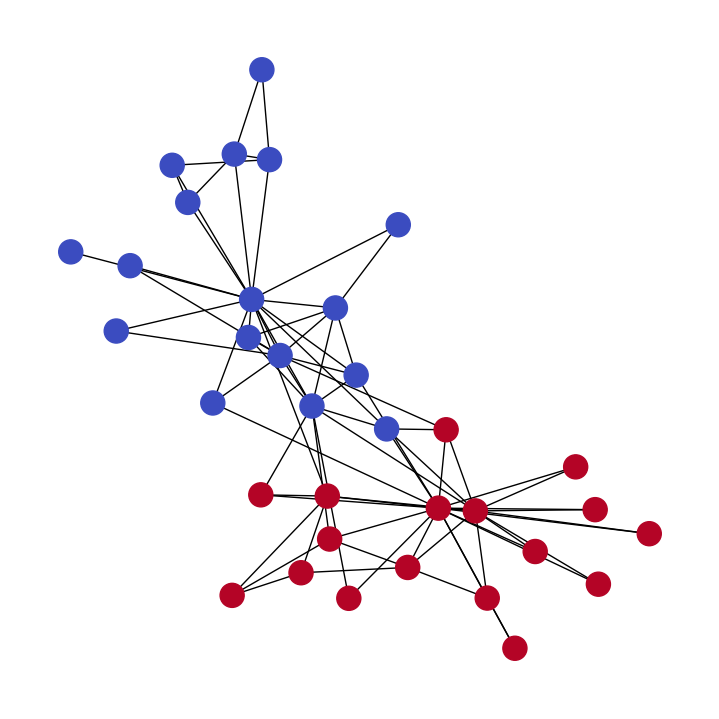

In [ ]:
from pylab import show
G = nx.karate_club_graph()
community_map = {}

for node in G.nodes(data=True):
    if node[1]["club"] == "Mr. Hi":
        community_map[node[0]] = 0
    else:
        community_map[node[0]] = 1
node_color = []
color_map = {0:0, 1:1}
node_color = [color_map[community_map[node]] for node in G.nodes()]
pos = nx.spring_layout(G)
plt.figure(figsize=(7,7))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color)
show()

### Question 1.1: Assign Node Type and Node features

In [ ]:
def assign_node_types(G, community_map):
    node_types = {k: "n" + str(v) for (k, v) in community_map.items()}
    nx.classes.function.set_node_attributes(G, values=node_types, name="node_type")

In [ ]:
def assign_node_labels(G, community_map):
    nx.classes.function.set_node_attributes(G, values=community_map, name="node_label")

In [ ]:
def assign_node_features(G):
  nx.classes.function.set_node_attributes(G,values=torch.tensor([1.,1.,1.,1.,1.]),name="node_feature")

In [ ]:
assign_node_types(G, community_map)
assign_node_labels(G, community_map)
assign_node_features(G)

# Explore node properties for the node with id: 20
node_id = 20
print(f"Node {node_id} has properties:", G.nodes(data=True)[node_id])

Node 20 has properties: {'club': 'Officer', 'node_type': 'n1', 'node_label': 1, 'node_feature': tensor([1., 1., 1., 1., 1.])}


### Question 1.2: Assigning Edge Types

In [ ]:
def assign_edge_types(G, community_map):
    # TODO: Implement a function that takes in a NetworkX graph
    # G and community map assignment (mapping node id --> 0/1 label)
    # and adds 'edge_type' as a edge_attribute in G.

    ############# Your code here ############
    ## (~5 line of code)
    ## Note
    ## 1. Create an edge assignment dict following rules above
    ## 2. Look up NetworkX `nx.classes.function.set_edge_attributes`
    
    community_to_edge_type = {0: "e0", 1: "e1"}
    edge_type = {
        edge: "e2"
        if community_map[edge[0]] != community_map[edge[1]]
        else community_to_edge_type[community_map[edge[0]]]
        for edge in G.edges()
    }
    nx.classes.set_edge_attributes(G, values=edge_type, name='edge_type')


In [ ]:
assign_edge_types(G, community_map)

# Explore edge properties for a sampled edge and check the corresponding
# node types
edge_idx = 15
n1 = 0
n2 = 31
edge = list(G.edges(data=True))[edge_idx]
print (f"Edge ({edge[0]}, {edge[1]}) has properties:", edge[2])
print (f"Node {n1} has properties:", G.nodes(data=True)[n1])
print (f"Node {n2} has properties:", G.nodes(data=True)[n2])

Edge (0, 31) has properties: {'weight': 2, 'edge_type': 'e2'}
Node 0 has properties: {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': tensor([1., 1., 1., 1., 1.])}
Node 31 has properties: {'club': 'Officer', 'node_type': 'n1', 'node_label': 1, 'node_feature': tensor([1., 1., 1., 1., 1.])}


### Graph Visualization

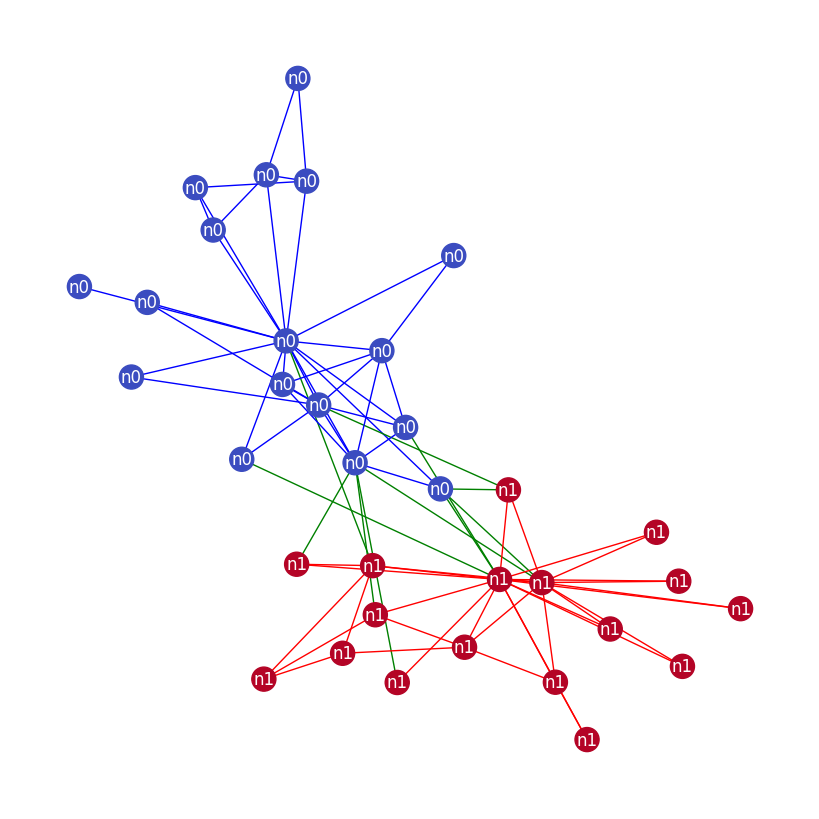

In [ ]:
edge_color = {}
for edge in G.edges():
    n1, n2 = edge
    edge_color[edge] = community_map[n1] if community_map[n1] == community_map[n2] else 2
    if community_map[n1] == community_map[n2] and community_map[n1] == 0:
      edge_color[edge] = 'blue'
    elif community_map[n1] == community_map[n2] and community_map[n1] == 1:
      edge_color[edge] = 'red'
    else:
      edge_color[edge] = 'green'

G_orig = copy.deepcopy(G)
nx.classes.function.set_edge_attributes(G, edge_color, name='color')
colors = nx.get_edge_attributes(G,'color').values()
labels = nx.get_node_attributes(G, 'node_type')
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color, edge_color=colors, labels=labels, font_color='white')
show()

### Transforming to DeepSNAP representation

In [ ]:
from deepsnap.hetero_graph import HeteroGraph

In [ ]:
hete = HeteroGraph(G_orig)

### Question 1.3: How many nodes are of each type?

In [ ]:
def get_nodes_per_type(hete):
    num_nodes_n0 = hete.num_nodes('n0')
    num_nodes_n1 = hete.num_nodes('n1')
    
    return num_nodes_n0, num_nodes_n1

In [ ]:
num_nodes_n0, num_nodes_n1 = get_nodes_per_type(hete)
print("Node type n0 has {} nodes".format(num_nodes_n0))
print("Node type n1 has {} nodes".format(num_nodes_n1))

Node type n0 has 17 nodes
Node type n1 has 17 nodes


### Question 1.4: Message Types: How many edges are of each message type?

In [ ]:
hete.message_types

[('n0', 'e0', 'n0'), ('n0', 'e2', 'n1'), ('n1', 'e1', 'n1')]

In [ ]:
list(hete.num_edges(hete.message_types).items())

[(('n0', 'e0', 'n0'), 35), (('n0', 'e2', 'n1'), 11), (('n1', 'e1', 'n1'), 32)]

In [ ]:
def get_num_message_edges(hete):
    message_type_edges = hete.num_edges(hete.message_types)
    return list(message_type_edges.items())

In [ ]:
message_type_edges = get_num_message_edges(hete)
for message_type, num_edges in message_type_edges:
    print("Message type {} has {} edges".format(message_type, num_edges))

Message type ('n0', 'e0', 'n0') has 35 edges
Message type ('n0', 'e2', 'n1') has 11 edges
Message type ('n1', 'e1', 'n1') has 32 edges


### Question 1.5: Dataset splitting - How many nodes are in each dataset split?

In [ ]:
from deepsnap.dataset import GraphDataset

In [ ]:
def compute_dataset_split_counts(datasets):
    num_labeled_nodes_per_dataset = {}
    for dataset_name, data in datasets.items():
        num_labeled_nodes_per_dataset[dataset_name] = {}
        data = data[0]
        for node_type, index in data.node_label_index.items():
            num_labeled_nodes_per_dataset[dataset_name][node_type] = index.size()[0]
    return num_labeled_nodes_per_dataset

In [ ]:
dataset = GraphDataset([hete], task='node')
# Splitting the dataset
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
datasets = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

data_set_splits = compute_dataset_split_counts(datasets)
for dataset_name, num_nodes in data_set_splits.items():
    print("{} dataset has {} nodes".format(dataset_name, num_nodes))

train dataset has {'n0': 6, 'n1': 6} nodes
val dataset has {'n0': 5, 'n1': 5} nodes
test dataset has {'n0': 6, 'n1': 6} nodes


### DeepSNAP Dataset Visualization

In [ ]:
hete._convert_to_graph_index(dataset[0].node_label_index['n0'], 'n0')

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 16, 17, 19, 21])

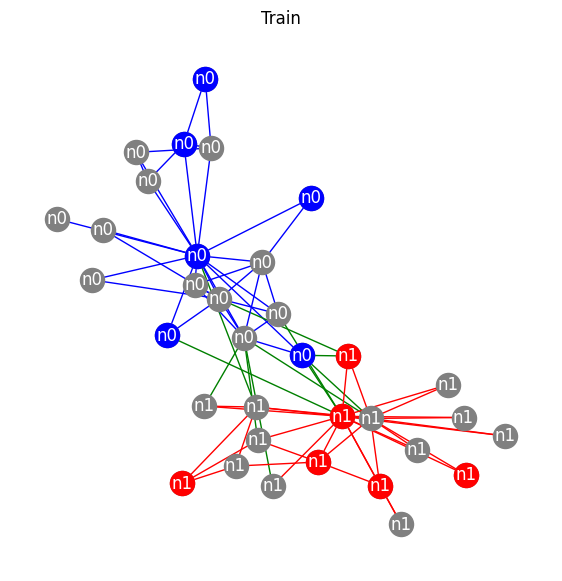

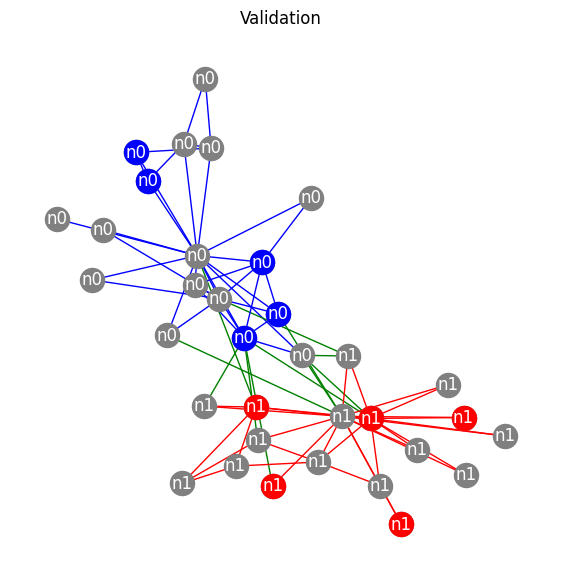

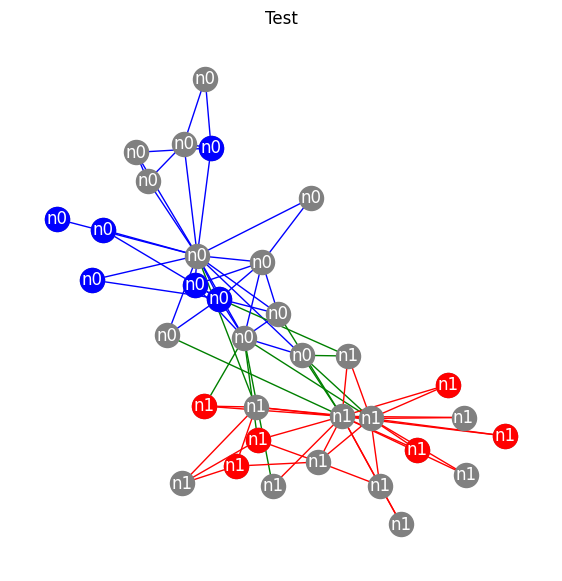

In [ ]:
dataset = GraphDataset([hete], task='node')
# Splitting the dataset
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
titles = ['Train', 'Validation', 'Test']

for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
    n0 = hete._convert_to_graph_index(dataset[0].node_label_index['n0'], 'n0').tolist()
    n1 = hete._convert_to_graph_index(dataset[0].node_label_index['n1'], 'n1').tolist()

    plt.figure(figsize=(7, 7))
    plt.title(titles[i])
    nx.draw(G_orig, pos=pos, node_color="grey", edge_color=colors, labels=labels, font_color='white')
    nx.draw_networkx_nodes(G_orig.subgraph(n0), pos=pos, node_color="blue")
    nx.draw_networkx_nodes(G_orig.subgraph(n1), pos=pos, node_color="red")
    show()

## Heterogeneous Graph Node Property Prediction

In [ ]:
import copy
import torch
import deepsnap
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from sklearn.metrics import f1_score
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from torch_sparse import SparseTensor, matmul

In [ ]:
data = torch.load("colabs_data/acm.pkl")

In [ ]:
from typing import Union


from torch import Tensor
from torch_sparse import SparseTensor

import torch_sparse

In [ ]:
class HeteroGNNConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels_src, in_channels_dst, out_channels):
        super(HeteroGNNConv, self).__init__(aggr="mean")
        self.in_channels_src = in_channels_src
        self.in_channels_dst = in_channels_dst
        self.out_channels = out_channels

        self.lin_dst = nn.Linear(in_channels_dst, out_channels)
        self.lin_src = nn.Linear(in_channels_src, out_channels)

        self.lin_update = nn.Linear(out_channels*2, out_channels)

    def forward(
            self,
            node_feature_src,
            node_feature_dst,
            edge_index,
            size=None
    ):
        return self.propagate(edge_index=edge_index, node_feature_src=node_feature_src, 
                              node_feature_dest=node_feature_dst, size=size)

    def message_and_aggregate(self, edge_index, node_feature_src):
        return torch_sparse.matmul(edge_index, node_feature_src, reduce=self.aggr)
    
    def update(self, aggr_out, node_feature_dest):
        aggr_out = self.lin_src(aggr_out)
        feature_dest = self.lin_dst(node_feature_dest)
        aggr_out = torch.cat([aggr_out,feature_dest], dim=1)
        aggr_out = self.lin_update(aggr_out)
        return aggr_out

In [ ]:
class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
    def __init__(self, convs, args, aggr="mean"):
        super(HeteroGNNWrapperConv, self).__init__(convs, None)
        self.aggr = aggr

        self.mapping = {}

        self.alpha = None # numpy array

        self.attn_proj = None

        if self.aggr == "attn":
            pass
            # self.attn_proj = nn.Sequential(nn.Linear(), nn.Tanh())

    def reset_parameters(self):
        super(HeteroGNNWrapperConv, self).reset_parameters()
        if self.aggr == "attn":
            for layer in self.attn_proj.children():
                layer.reset_parameters()
    
    def forward(self, node_features, edge_indices):
        message_type_emb = {}
        for message_key, message_type in edge_indices.items():
            src_type, edge_type, dst_type = message_key
            node_feature_src = node_features[src_type]
            node_feature_dst = node_features[dst_type]
            edge_index = edge_indices[message_key]
            message_type_emb[message_key] = (
                self.convs[message_key](
                node_feature_src,
                node_feature_dst,
                edge_index
                )
            )
        node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
        mapping = {}
        for (src, edge_type, dst), item in message_type_emb.items():
            mapping[len(node_emb[dst])] = (src, edge_type, dst)
            node_emb[dst].append(item)
        self.mapping = mapping

        for node_type, embs in node_emb.items():
            if len(embs) == 1:
                node_emb[node_type] = embs[0]
            else:
                node_emb[node_type] = self.aggregate(embs)
        return node_emb
    
    def aggregate(self, xs):
        if self.aggr == "mean":
            return torch.mean(torch.stack(xs))
        elif self.aggr == "attn":
            N = xs[0].shape[0] # Number of nodes for that node type
            M = len(xs) # Number of message types for that node type

            x = torch.cat(xs, dim=0).view(M, N, -1) # M * N * D
            z = self.attn_proj(x).view(M,N)
            z = z.mean(1)
            alpha = torch.softmax(z, dim=0)
            self.alpha = alpha.view(-1).data.cpu().numpy()

            alpha = alpha.view(M, 1, 1)
            x = x * alpha
            return x.sum(dim=0)

In [ ]:
def generate_convs(hetero_graph, conv, hidden_size, first_layer=False):
    convs = {}
    message_types = hetero_graph.message_types
    for m in message_types:
        s, r, d = m
        src_in_channels = hidden_size
        dst_in_channels = hidden_size
        if first_layer:
            src_in_channels = hetero_graph.num_node_features(s)
            dst_in_channels = hetero_graph.num_node_features(d)
        convs[m] = conv(src_in_channels, dst_in_channels, hidden_size)
    return convs

### HeteroGNN

In [ ]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hetero_graph, args, aggr="mean"):
        super(HeteroGNN, self).__init__()

        self.aggr = aggr
        self.hidden_size = args["hidden_size"]

        self.convs1 = None
        self.convs2 = None

        self.bns1 = nn.ModuleDict()
        self.bns2 = nn.ModuleDict()
        self.relus1 = nn.ModuleDict()
        self.relus2 = nn.ModuleDict()
        self.post_mps = nn.ModuleDict()

        self.convs1 = HeteroGNNWrapperConv(
            generate_convs(
                hetero_graph, HeteroGNNConv, self.hidden_size, True
            ),
            args,
        )
        self.convs2 = HeteroGNNWrapperConv(
            generate_convs(
                hetero_graph, HeteroGNNConv, self.hidden_size, False
            ),
            args,
        )
        for node_type in hetero_graph.node_types:
            self.bns1[node_type] = nn.BatchNorm1d(self.hidden_size, eps=1)
            self.bns2[node_type] = nn.BatchNorm1d(self.hidden_size, eps=1)
            self.relus1[node_type] = nn.LeakyReLU()
            self.relus2[node_type] = nn.LeakyReLU()
            num_labels = hetero_graph.num_node_labels(node_type)
            self.post_mps[node_type] = nn.Linear(self.hidden_size, num_labels)
    
    def forward(self, node_feature, edge_index):
        x = node_feature
        x = self.convs1(x, edge_index)
        x = hetero_gnn.forward_op(x, self.bns1)
        x = hetero_gnn.forward_op(x, self.relus1)
        x = self.convs2(x, edge_index)
        x = hetero_gnn.forward_op(x, self.bns2)
        x = hetero_gnn.forward_op(x, self.relus2)
        out = hetero_gnn.forward_op(x, self.post_mps)
        return out

    def loss(self, preds, y, indices):
        loss = 0
        loss_func = F.cross_entropy
        for node_type in indices.keys():
            idx = indices[node_type]
            loss += loss_func(preds[node_type][idx], y[node_type][idx])
        return loss

### Training and Testing

In [ ]:
import pandas as pd

def train(model, optimizer, hetero_graph, train_idx):
    model.train()
    optimizer.zero_grad()
    preds = model(hetero_graph.node_feature, hetero_graph.edge_index)

    loss = None

    ############# Your code here #############
    ## Note:
    ## 1. Compute the loss here
    ## 2. `deepsnap.hetero_graph.HeteroGraph.node_label` is useful
    loss = model.loss(preds, hetero_graph.node_label, train_idx)


    ##########################################

    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, graph, indices, best_model=None, best_val=0, save_preds=False, agg_type=None):
    model.eval()
    accs = []
    for i, index in enumerate(indices):
        preds = model(graph.node_feature, graph.edge_index)
        num_node_types = 0
        micro = 0
        macro = 0
        for node_type in preds:
            idx = index[node_type]
            pred = preds[node_type][idx]
            pred = pred.max(1)[1]
            label_np = graph.node_label[node_type][idx].cpu().numpy()
            pred_np = pred.cpu().numpy()
            micro = f1_score(label_np, pred_np, average='micro')
            macro = f1_score(label_np, pred_np, average='macro')
            num_node_types += 1
                  
        # Averaging f1 score might not make sense, but in our example we only
        # have one node type
        micro /= num_node_types
        macro /= num_node_types
        accs.append((micro, macro))

        # Only save the test set predictions and labels!
        if save_preds and i == 2:
          print ("Saving Heterogeneous Node Prediction Model Predictions with Agg:", agg_type)
          print()

          data = {}
          data['pred'] = pred_np
          data['label'] = label_np

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('ACM-Node-' + agg_type + 'Agg.csv', sep=',', index=False)

    if accs[1][0] > best_val:
        best_val = accs[1][0]
        best_model = copy.deepcopy(model)
    return accs, best_model, best_val

In [ ]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 64,
    'epochs': 100,
    'weight_decay': 1e-5,
    'lr': 0.003,
    'attn_size': 32,
}

In [ ]:
print(f"Device: {args['device']}")

Device: cpu


In [ ]:
import gcsfs
fs = gcsfs.GCSFileSystem(project="prj-cgh-aud-idn-npd-amer")
fs.ls('gcs-gcp-cgh-aud-idn-npd-usw1/experiment_mohammad')

['gcs-gcp-cgh-aud-idn-npd-usw1/experiment_mohammad/',
 'gcs-gcp-cgh-aud-idn-npd-usw1/experiment_mohammad/acm.pkl']

In [ ]:
with fs.open('gcs-gcp-cgh-aud-idn-npd-usw1/experiment_mohammad/acm.pkl', 'rb') as f:
    data = torch.load(f)

In [ ]:
data

{'label': tensor([0, 0, 0,  ..., 2, 2, 2]),
 'feature': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]]),
 'pap': tensor([[   0,    0,    0,  ..., 3024, 3024, 3024],
         [   8,   20,   51,  ..., 2948, 2983, 2991]]),
 'psp': tensor([[   0,    0,    0,  ..., 3024, 3024, 3024],
         [  75,  434,  534,  ..., 3020, 3021, 3022]]),
 'train_idx': tensor([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
           12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
           24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
           36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
           48,   49,   50,   51,   52,   53,   54,   55,   56,   57,   58,   59,
           60,   61,   62,   63,   

In [ ]:
message_type_1 = ("paper", "auther", "paper")
message_type_2 = ("paper", "subject", "paper")

In [ ]:
edge_index = {}
edge_index[message_type_1] = data['pap']
edge_index[message_type_2] = data['psp']

In [ ]:
node_feature = {}
node_feature["paper"] = data['feature']

In [ ]:
node_feature['paper'].shape

torch.Size([3025, 1870])

In [ ]:
node_label = {}
node_label["paper"] = data['label']

In [ ]:
data.keys()

dict_keys(['label', 'feature', 'pap', 'psp', 'train_idx', 'val_idx', 'test_idx'])

In [ ]:
train_idx = {"paper":data['train_idx'].to(args['device'])}
val_idx = {"paper":data['val_idx'].to(args['device'])}
test_idx = {"paper":data['test_idx'].to(args['device'])}

In [ ]:
hetero_graph = HeteroGraph(
    node_feature=node_feature,
    node_label=node_label,
    edge_index=edge_index,
    directed=True
)

In [ ]:
print(f"ACM heterogeneous graph: {hetero_graph.num_nodes()} nodes, {hetero_graph.num_edges()} edges")

ACM heterogeneous graph: {'paper': 3025} nodes, {('paper', 'auther', 'paper'): 26256, ('paper', 'subject', 'paper'): 2207736} edges


In [ ]:
for key in hetero_graph.node_feature:
    hetero_graph.node_feature[key] = hetero_graph.node_feature[key].to(args['device'])

for key in hetero_graph.node_label:
    hetero_graph.node_label[key] = hetero_graph.node_label[key].to(args['device'])

In [ ]:
for key in hetero_graph.edge_index:
    edge_index = hetero_graph.edge_index[key]
    adj = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(hetero_graph.num_nodes(key[0]), hetero_graph.num_nodes(key[2])))
    hetero_graph.edge_index[key] = adj.t().to(args['device'])

In [ ]:
print(hetero_graph.edge_index[message_type_1])
print(hetero_graph.edge_index[message_type_2])

SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024]),
             col=tensor([   8,   20,   51,  ..., 2948, 2983, 2991]),
             size=(3025, 3025), nnz=26256, density=0.29%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024]),
             col=tensor([  75,  434,  534,  ..., 3020, 3021, 3022]),
             size=(3025, 3025), nnz=2207736, density=24.13%)


In [ ]:
best_model = None
best_val = 0

model = HeteroGNN(hetero_graph=hetero_graph, args=args, aggr="mean").to(args["device"])
optimizer = torch.optim.Adam(
    model.parameters(), lr=args["lr"], weight_decay=args["weight_decay"]
)

for epoch in range(args["epochs"]):
    loss = train(model, optimizer, hetero_graph, train_idx)
    accs, best_model, best_val = test(
        model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val
    )
    print(
        f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
        f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
        f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
        f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
    )
best_accs, _, _ = test(
    best_model,
    hetero_graph,
    [train_idx, val_idx, test_idx],
    save_preds=True,
    agg_type="Mean",
)
print(
    f"Best model: "
    f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
    f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
    f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
)

AttributeError: 'dict' object has no attribute 'unsqueeze'